##**Import Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

##**Load and Preprocess the Dataset**

In [17]:
import pandas as pd
df = pd.read_csv('/content/weather_data.csv')

print(df.head())

# Correct column name case and set 'date' as datetime and index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Keep only the 'temperature' column
data = df['temperature'].values.reshape(-1, 1)

# Normalize the temperature data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Split the data into training and testing sets
split_ratio = 0.8
split_idx = int(len(data_normalized) * split_ratio)
train_data = data_normalized[:split_idx]
test_data = data_normalized[split_idx:]

print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")


         date  temperature
0  2014-01-01    10.248357
1  2014-01-02     9.950428
2  2014-01-03    10.362958
3  2014-01-04    10.820167
4  2014-01-05     9.961091
Train data shape: (2045, 1), Test data shape: (512, 1)


##**Prepare Data for LSTM Input**

In [6]:
# Function to create sequences
def create_sequences(data, time_steps=30):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
    return np.array(sequences)

# Create sequences with a time step of 30 days
time_steps = 30
X_train = create_sequences(train_data, time_steps)
X_test = create_sequences(test_data, time_steps)

print(f"Training sequences shape: {X_train.shape}, Testing sequences shape: {X_test.shape}")


Training sequences shape: (2015, 30, 1), Testing sequences shape: (482, 30, 1)


##**Build the LSTM Autoencoder Model**

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Define the model architecture
input_dim = X_train.shape[2]  # Number of features (1 in this case)
latent_dim = 16  # Size of the latent space

# Encoder
inputs = Input(shape=(time_steps, input_dim))
encoded = LSTM(latent_dim, activation='relu', return_sequences=False)(inputs)

# Decoder
decoded = RepeatVector(time_steps)(encoded)
decoded = LSTM(input_dim, activation='relu', return_sequences=True)(decoded)

# Autoencoder Model
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 1)               │              72 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,224 (4.78 KB)

 Trainable params: 1,224 (4.78 KB)

 Non-trainable params: 0 (0.00 B)

##**Train the Autoencoder**

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2362 - val_loss: 0.0091
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0

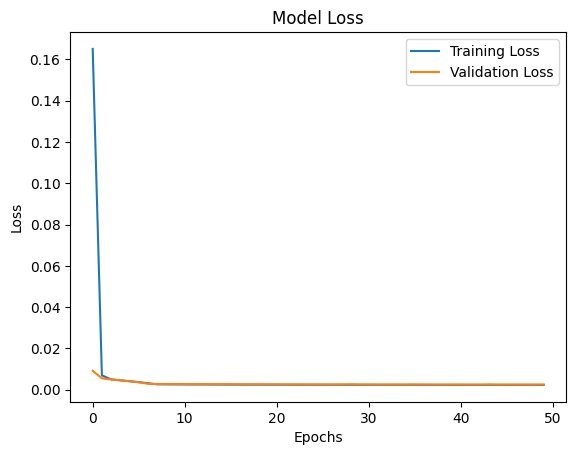

In [8]:
# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##**Evaluate and Detect Anomalies**

In [9]:
# Reconstruct the test data
reconstructed = autoencoder.predict(X_test)

# Calculate reconstruction errors
reconstruction_errors = np.mean((X_test - reconstructed) ** 2, axis=(1, 2))

# Set a threshold for anomaly detection (e.g., 95th percentile)
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly detection threshold: {threshold}")

# Identify anomalies
anomalies = reconstruction_errors > threshold
anomaly_indices = np.where(anomalies)[0]

print(f"Number of anomalies detected: {len(anomaly_indices)}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Anomaly detection threshold: 0.005909537264963676
Number of anomalies detected: 25


Threshold: The anomaly detection threshold is 0.0059, representing significant deviations from normal temperature patterns.

Anomalies Detected: The model identified 25 anomalies in the test data, indicating unusual temperature readings.

##**Visualize the Results**

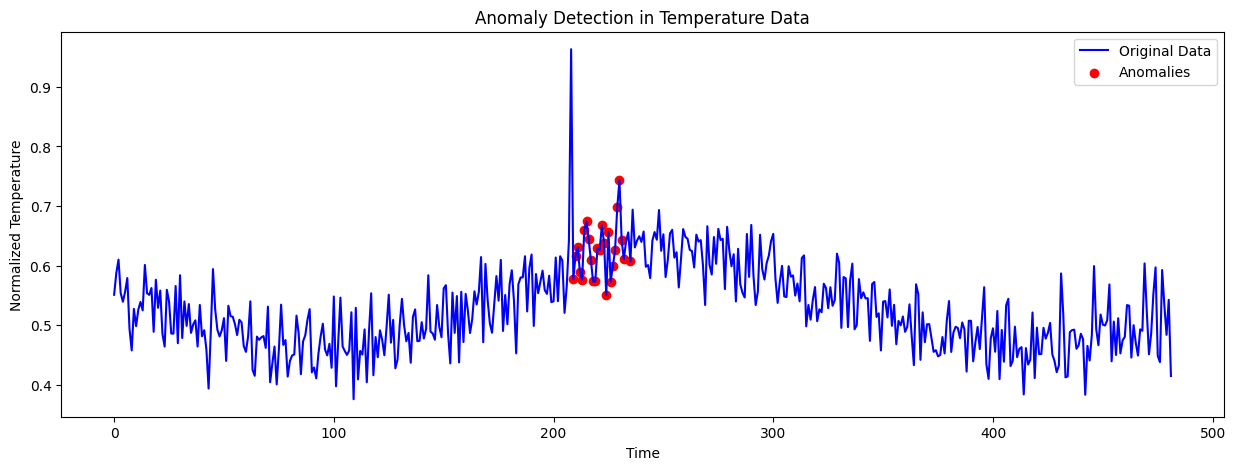

In [10]:
# Flatten the test data to align with anomaly indices
test_data_flattened = test_data[time_steps:]

plt.figure(figsize=(15, 5))
plt.plot(test_data_flattened, label='Original Data', color='blue')
plt.scatter(anomaly_indices, test_data_flattened[anomaly_indices], color='red', label='Anomalies')
plt.title('Anomaly Detection in Temperature Data')
plt.xlabel('Time')
plt.ylabel('Normalized Temperature')
plt.legend()
plt.show()


The **blue line** shows normalized temperature trends, while **red dots** mark anomalies with errors above the threshold.

The graph shows that anomalies (red dots) are clustered around a sudden spike in temperature, indicating the model's sensitivity to sharp deviations from normal patterns. These anomalies align with irregular fluctuations or transitions, suggesting they may be linked to specific events or periods of instability. This highlights the autoencoder's effectiveness in detecting unusual changes, which can be further investigated for potential causes like environmental factors or sensor malfunctions.